<a href="https://colab.research.google.com/github/Arjune7/dataset/blob/main/churn-prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Churn-predictor**

In [ ]:
import pandas as pd
import io
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc



from scipy.stats import randint
from sklearn.svm import SVC

import joblib

# **Load Data**

In [ ]:
from google.colab import files
data_to_load = files.upload()

Saving customer_churn_large_dataset.csv to customer_churn_large_dataset (2).csv


In [ ]:
df = pd.read_csv(io.BytesIO(data_to_load['customer_churn_large_dataset (2).csv']))

# **Data Prepartion**

## **Data Cleaning**

In [ ]:
# Handling missing values (if any)
df.dropna(inplace=True)  # Dropping rows with missing values

# Encoding categorical variables
label_encoders = {}
categorical_cols = ['Gender', 'Location']
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])

# Scaling numerical features
numerical_cols = ['Age', 'Subscription_Length_Months', 'Monthly_Bill', 'Total_Usage_GB']
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Handling outliers (assuming a simple method to remove outliers)
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# Splitting the features and target variable
X = df.drop(columns=['CustomerID', 'Name', 'Churn'])
y = df['Churn']

## **Feature Engineering**

In [ ]:
# Subscription to Age Ratio:
df['Subscription_to_Age_Ratio'] = df['Subscription_Length_Months'] / df['Age']

# Monthly Bill per GB:
df['Cost_Per_GB'] = df['Monthly_Bill'] / df['Total_Usage_GB']

# List of new feature columns that need to be scaled
new_feature_cols = ['Subscription_to_Age_Ratio', 'Cost_Per_GB']

# Initialize the scaler
scaler = StandardScaler()

# Apply standard scaling to the new features in the entire dataset
df[new_feature_cols] = scaler.fit_transform(df[new_feature_cols])


## **Data Splitting**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **Model Training**

## **Logistic Regression**

In [ ]:
# Initializing and training the Logistic Regression model
logreg_model = LogisticRegression(random_state=42)
logreg_model.fit(X_train, y_train)

LogisticRegression(random_state=42)

### **Model Evaluation**

Test Accuracy: 0.50

Classification Report on Test Data:
              precision    recall  f1-score   support

   Not Churn       0.50      0.62      0.56     10079
       Churn       0.50      0.38      0.43      9921

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.49     20000
weighted avg       0.50      0.50      0.49     20000



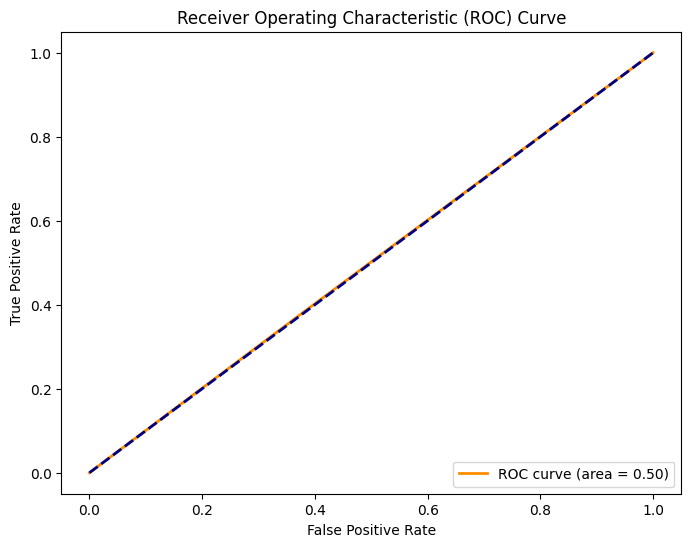

In [ ]:
# Evaluating the model on the test set
test_predictions = logreg_model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Generating a classification report for the test set
print("\nClassification Report on Test Data:")
print(classification_report(y_test, test_predictions, target_names=['Not Churn', 'Churn']))

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, test_predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### **Model Optimization**

#### **Cross-validation**

In [ ]:
# Perform 5-fold cross-validation
cv_scores = cross_val_score(logreg_model, X, y, cv=5, scoring='accuracy')

print("Cross-Validation Scores:")
print(cv_scores)
print(f"Mean Accuracy: {cv_scores.mean():.2f}")

Cross-Validation Scores:
[0.49705 0.50275 0.50315 0.5006  0.5062 ]
Mean Accuracy: 0.50


#### **Hyperparameter Tuning using Grid Search**

In [ ]:

# Define hyperparameters and their possible values
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'penalty': ['l2']  # Regularization type
}

# Initialize the model
logreg = LogisticRegression(random_state=42)

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)

# Print the best parameters found by grid search
print("Best Hyperparameters:")
print(grid_search.best_params_)

# Get the best model
best_model = grid_search.best_estimator_

Best Hyperparameters:
{'C': 1, 'penalty': 'l2'}


### **Model Evaluation after optimization**

Test Accuracy: 0.51

Classification Report on Test Data:
              precision    recall  f1-score   support

   Not Churn       0.51      0.70      0.59     10079
       Churn       0.50      0.31      0.38      9921

    accuracy                           0.51     20000
   macro avg       0.50      0.50      0.49     20000
weighted avg       0.50      0.51      0.49     20000



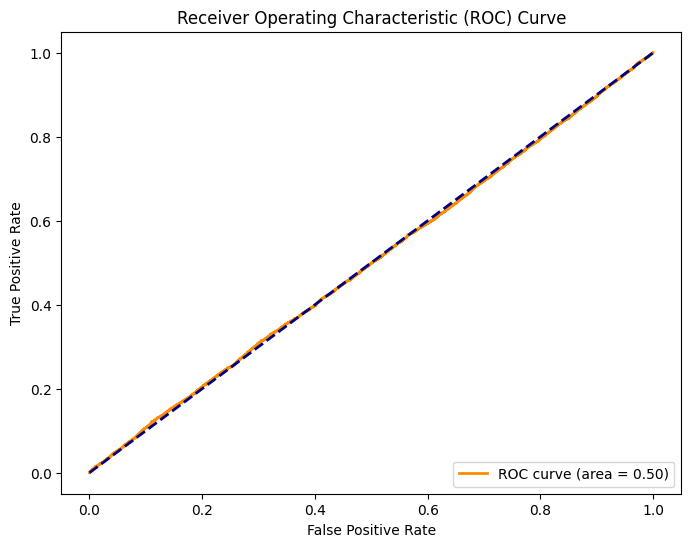

In [ ]:
# Evaluating the model on the test set
test_predictions = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Generating a classification report for the test set
print("\nClassification Report on Test Data:")
print(classification_report(y_test, test_predictions, target_names=['Not Churn', 'Churn']))

# Calculate ROC curve
probs = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


## **Random Forest Classifier**

In [ ]:
# Initialize and train the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### **Model Evaluation**

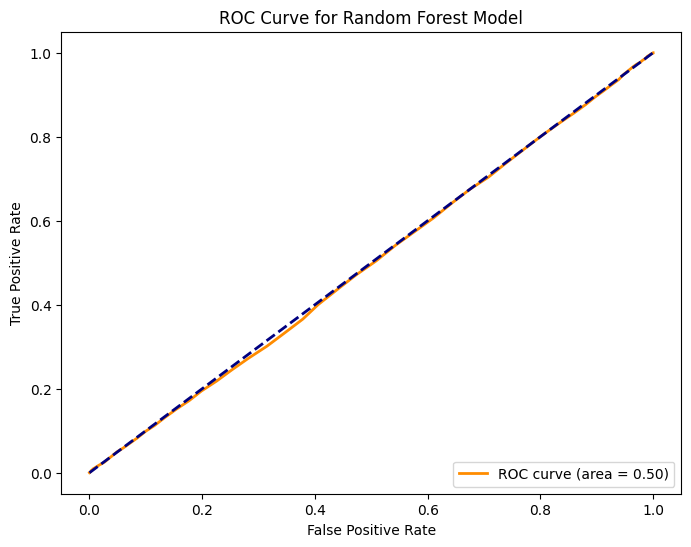

Test Accuracy for Random Forest : 0.50

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.50      0.53      0.51     10079
           1       0.49      0.47      0.48      9921

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.50      0.50      0.50     20000



In [ ]:
# Predict using the Random Forest model
predictions_rf = rf_model.predict(X_test)

# Assuming y_test contains the true labels for your test dataset
# Get probabilities for positive class for ROC curve
probs_rf = rf_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, probs_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC curve for the Random Forest model
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest Model')
plt.legend(loc='lower right')
plt.show()


# Print accuracy scores and formatted classification reports
test_predictions_rf = rf_model.predict(X_test)
test_accuracy_rf= accuracy_score(y_test, test_predictions_rf)

print(f"Test Accuracy for Random Forest : {test_accuracy_rf:.2f}")
print("\nClassification Report for Random Forest:")
print(classification_report(y_test, test_predictions_rf))

### **Model optimization**

#### **Cross validation**

In [ ]:
# Perform 5-fold cross-validation on Random Forest
cv_scores_rf = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')

print("Cross-Validation Scores for Random Forest:")
print(cv_scores_rf)
print(f"Mean Accuracy: {cv_scores_rf.mean():.2f}")

Cross-Validation Scores for Random Forest:
[0.4993  0.5007  0.4951  0.49655 0.4993 ]
Mean Accuracy: 0.50


#### **Hyperparameter tuning using Grid Search**

In [ ]:
# Define reduced hyperparameters and their possible values for Random Forest
param_grid_rf_reduced = {
    'n_estimators': [50, 100],
    'max_depth': [None, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize the Random Forest Classifier
rf_model_reduced = RandomForestClassifier(random_state=42)

# Perform grid search with 3-fold cross-validation for Random Forest with reduced search space
grid_search_rf_reduced = GridSearchCV(rf_model_reduced, param_grid_rf_reduced, cv=3, scoring='accuracy')
grid_search_rf_reduced.fit(X, y)

# Print the best parameters found by grid search for Random Forest (reduced search space)
print("Best Hyperparameters for Random Forest (Reduced Search Space):")
print(grid_search_rf_reduced.best_params_)

# Get the best Random Forest model with reduced search space
best_rf_model_reduced = grid_search_rf_reduced.best_estimator_


Best Hyperparameters for Random Forest (Reduced Search Space):
{'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


### **Model Evaluation after optimization**

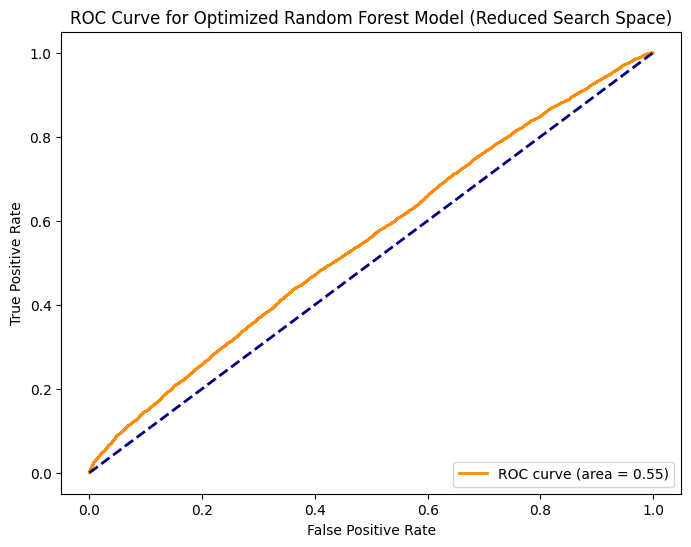

Test Accuracy for Random Forest (Optimized with Reduced Search Space): 0.53

Classification Report for Random Forest (Optimized with Reduced Search Space):
              precision    recall  f1-score   support

           0       0.53      0.67      0.59     10079
           1       0.54      0.40      0.46      9921

    accuracy                           0.53     20000
   macro avg       0.54      0.53      0.53     20000
weighted avg       0.54      0.53      0.53     20000



In [ ]:
# Get probabilities for positive class for ROC curve
probs_rf_optimized_reduced = best_rf_model_reduced.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr_rf_optimized_reduced, tpr_rf_optimized_reduced, thresholds_rf_optimized_reduced = roc_curve(y_test, probs_rf_optimized_reduced)
roc_auc_rf_optimized_reduced = auc(fpr_rf_optimized_reduced, tpr_rf_optimized_reduced)

# Plot ROC curve for the optimized Random Forest model with reduced search space
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf_optimized_reduced, tpr_rf_optimized_reduced, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_rf_optimized_reduced:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Optimized Random Forest Model (Reduced Search Space)')
plt.legend(loc='lower right')
plt.show()

# Print accuracy scores and formatted classification reports
test_predictions_rf_optimized_reduced = best_rf_model_reduced.predict(X_test)
test_accuracy_rf_optimized_reduced = accuracy_score(y_test, test_predictions_rf_optimized_reduced)

print(f"Test Accuracy for Random Forest (Optimized with Reduced Search Space): {test_accuracy_rf_optimized_reduced:.2f}")
print("\nClassification Report for Random Forest (Optimized with Reduced Search Space):")
print(classification_report(y_test, test_predictions_rf_optimized_reduced))


## **Gradient Bosting CLassifier**

In [ ]:
# Initialize the GBM Classifier
gbm_model = GradientBoostingClassifier(random_state=42)

# Train the model on the training data
gbm_model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

### **Model Evaluation**

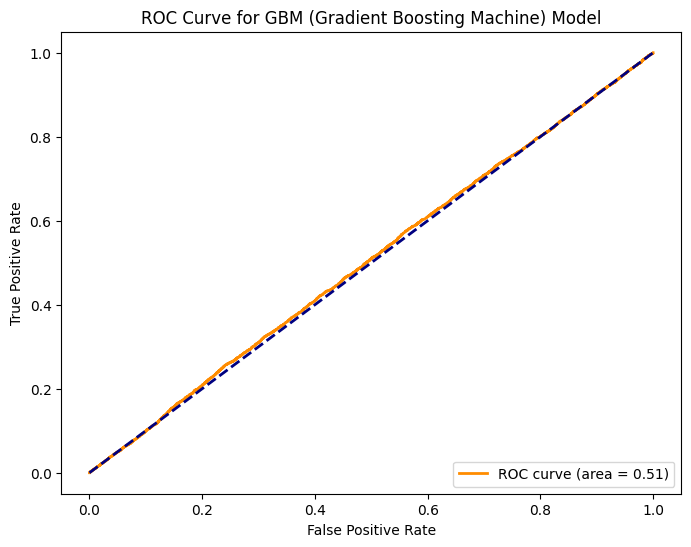

Test Accuracy for GBM: 0.50

Classification Report for GBM:
              precision    recall  f1-score   support

   Not Churn       0.50      0.62      0.56     10079
       Churn       0.50      0.38      0.43      9921

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.49     20000
weighted avg       0.50      0.50      0.49     20000



In [ ]:
# Get probabilities for positive class for ROC curve
probs_gbm = gbm_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr_gbm, tpr_gbm, thresholds_gbm = roc_curve(y_test, probs_gbm)
roc_auc_gbm = auc(fpr_gbm, tpr_gbm)

# Plot ROC curve for the GBM model
plt.figure(figsize=(8, 6))
plt.plot(fpr_gbm, tpr_gbm, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_gbm:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for GBM (Gradient Boosting Machine) Model')
plt.legend(loc='lower right')
plt.show()

# Print accuracy scores and formatted classification reports
print(f"Test Accuracy for GBM: {test_accuracy:.2f}")
print("\nClassification Report for GBM:")
print(classification_report(y_test, test_predictions, target_names=['Not Churn', 'Churn']))


### **Model Optimization**

#### **Cross-validation**

In [ ]:
# Assuming X and y are your feature matrix and target variable
gbm_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(gbm_model, X, y, cv=5, scoring='accuracy')


# Print cross-validation scores and mean accuracy
print("Cross-Validation Scores:")
print(cv_scores)
print(f"Mean Accuracy: {cv_scores.mean():.2f}")

Cross-Validation Scores:
[0.5101  0.49825 0.50555 0.5012  0.5053 ]
Mean Accuracy: 0.50


#### **Hyperparameter Tuning Using Grid Search**

In [ ]:
# Define the parameter grid for Grid Search
param_grid = {
    'n_estimators': [50, 100, 150],  # Number of boosting stages to be run
    'learning_rate': [0.01, 0.1, 0.2],  # Step size shrinkage to prevent overfitting
    'max_depth': [2, 3, 4]  # Maximum depth of the individual estimators (Reduced max_depth values)
}

# Initialize the GBM Classifier
gbm_model = GradientBoostingClassifier(random_state=42)

# Instantiate GridSearchCV with 3-fold cross-validation
grid_search = GridSearchCV(estimator=gbm_model, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Perform Grid Search to find the best hyperparameters
grid_search.fit(X, y)

# Print the best hyperparameters
print("Best Hyperparameters for GBM (3-fold Cross-Validation with Reduced max_depth):")
print(grid_search.best_params_)

# Get the best GBM model
best_gbm_model = grid_search.best_estimator_


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Hyperparameters for GBM (3-fold Cross-Validation with Reduced max_depth):
{'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 100}


### **Model Evaluation after optimzation**

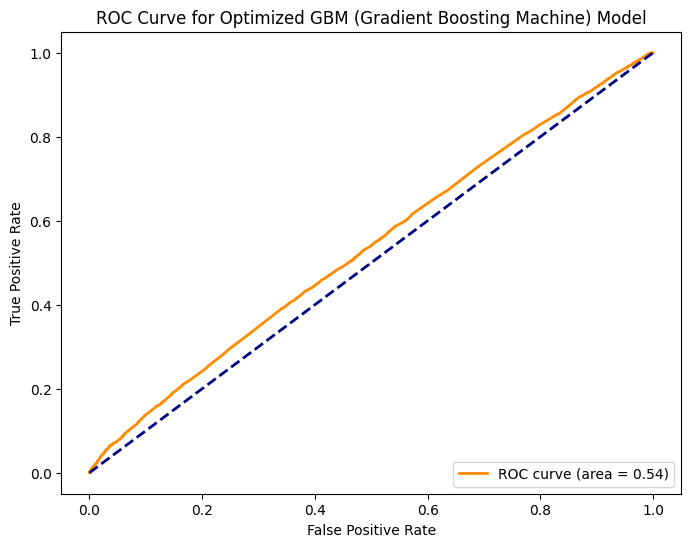

Test Accuracy for GBM (Optimized): 0.52
Classification Report for GBM (Optimized):
              precision    recall  f1-score   support

   Not Churn       0.52      0.80      0.63     10079
       Churn       0.54      0.24      0.34      9921

    accuracy                           0.52     20000
   macro avg       0.53      0.52      0.48     20000
weighted avg       0.53      0.52      0.48     20000



In [ ]:
# Get probabilities for positive class for ROC curve
probs_gbm_optimized = best_gbm_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr_gbm_optimized, tpr_gbm_optimized, thresholds_gbm_optimized = roc_curve(y_test, probs_gbm_optimized)
roc_auc_gbm_optimized = auc(fpr_gbm_optimized, tpr_gbm_optimized)

# Plot ROC curve for the optimized GBM model
plt.figure(figsize=(8, 6))
plt.plot(fpr_gbm_optimized, tpr_gbm_optimized, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_gbm_optimized:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Optimized GBM (Gradient Boosting Machine) Model')
plt.legend(loc='lower right')
plt.show()

# Predict using the optimized GBM model
predictions_gbm_optimized = best_gbm_model.predict(X_test)

# Calculate accuracy
test_accuracy_gbm_optimized = accuracy_score(y_test, predictions_gbm_optimized)

# Print test accuracy
print(f"Test Accuracy for GBM (Optimized): {test_accuracy_gbm_optimized:.2f}")

# Generate a classification report for detailed evaluation
print("Classification Report for GBM (Optimized):")
print(classification_report(y_test, predictions_gbm_optimized, target_names=['Not Churn', 'Churn']))


# **Saving the most accurate model**

In [ ]:
# Save the trained Random Forest model to a file
joblib.dump(best_rf_model_reduced, 'random_forest_churn_model.pkl')

['random_forest_churn_model.pkl']

# **making prediction with user input**

## **Using flask for deployment**

In [ ]:
from flask import Flask, request, jsonify

app = Flask(__name__)

# Load the trained Random Forest model
loaded_rf_model = joblib.load('random_forest_churn_model.pkl')

@app.route('/predict', methods=['POST'])
def predict():
    try:
        # Get data from the POST request
        data = request.get_json(force=True)
        # Assume data is a dictionary containing feature values
        features = [list(data.values())]
        # Use the loaded model to make predictions
        predictions = loaded_rf_model.predict(features)
        # Return the predictions as JSON response
        return jsonify(predictions.tolist())
    except Exception as e:
        return jsonify({'error': str(e)})

if __name__ == '__main__':
    app.run(port=5000)

### *example input*

In [ ]:
# import requests

# url = 'http://localhost:5000/predict'
# data = {...}  # Provide your feature values
# response = requests.post(url, json=data)

# print(response.json())
